In [1]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import pandas as pd
import os, sys
from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, KMeans as KM
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
src=f"{os.getcwd()}/src"
if src not in sys.path:
    sys.path.append(src)
from SimpleClustering import *

# Aprendizaje no supervisado

El aprendizaje no supervisado técnica de la en la que un modelo aprende a identificar patrones y estructuras en un conjunto de datos sin la necesidad de conocer la salidad. Se parte de un cojunto de datos no etiquetados características $X$, por lo generala los datos so agrupados en categorías en las que cada grupo son los objetos que presentan simulitudes entre ellos. El aprendizaje no supervisado es ampliamente utilizado en áreas como el análisis de datos, la segmentación de mercado, y el reconocimiento de patrones.

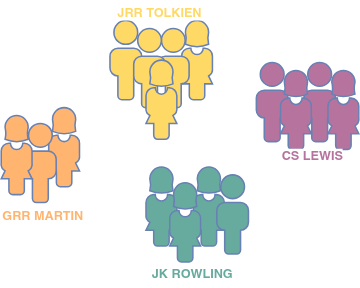

## Clustering
El proceso de clustering o agrupamiento, es un procedimiento de aprendizaje no supervisado utilizado para descrubir/explorar la estructura de una colección de
objetos. El objetivo es dividir el conjunto de objetos en grupos/clusters/clases de objetos **similares** mientras son separados de objetos **no similares**. Las clases generadas representan una generalización sobre los objetos y sus características.

Formalemete, el problema puede definirse como sigue: utilizando como entrada una colección de objetos $X$ y un valor entero $K$ se debe obtener un conjunto $G=\{G_1,G_2,...,G_K\}$. Donde cada objeto  $x_i \in X$ es un vector definido en $\mathbb{R}^N$,  se cumple que  $1 < K \leq |X|$. Al finalizar el proceso cada elemento $x_i$ debe pertenecer a uno de los grupos en $G$

#### Definiciones adicionales
- $m_k$ es el número de elementos en el grupo $G_k$, es decir $m_k=|G_k|$
- $c_k$ será utilizado para referirse al centroide de todos los elementos en $G_k$, el cuál puede ser:
    - la media geométrica $$c_k = \frac{1}{m_k} \sum_{i=1}^{m_k} x_i $$
    - la mediana
    - uno de los elementos en el grupo(centro)
- Se utilizará $M$ para hacer referencia al conjunto de centroides $\{c_1,c_2,...,c_k\}$.
- En el problema de clustering a considerar cada objeto $x_i$ solo pertenece a un grupo, por lo tanto  para cualquier par de grupos  $G_A, G_B$ donde $A \neq B$, se cumple que:
$$G_A \cap G_B = \emptyset$$.



In [3]:
# Un ejemplo de 3 clusters bien definidos con 100 puntos cada uno
# se utiliza un distribución gaussiana
from sklearn.datasets import make_blobs
blobs_centers = [[-4, 4], [-2, -4], [4, 0]]
blobs_data, blobs_labels = make_blobs(n_samples=300,centers=blobs_centers,
                                      random_state=0,cluster_std=[1.7,1.8, 1.2])
blobs_classes =dict(zip(set(blobs_labels),blobs_centers))
print(blobs_classes)

{np.int64(0): [-4, 4], np.int64(1): [-2, -4], np.int64(2): [4, 0]}


In [4]:
blobs_classes

{np.int64(0): [-4, 4], np.int64(1): [-2, -4], np.int64(2): [4, 0]}

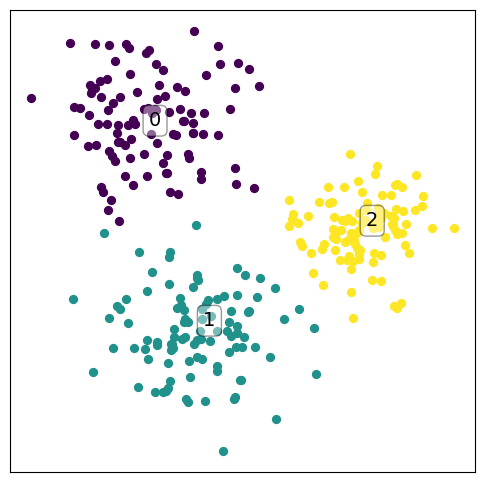

In [5]:
# La función plotCusters está definida en skeleton.py
plotClusters(blobs_data,blobs_labels,centroids=blobs_classes)

In [6]:
# Cluster de 4 dimesiones
data= load_iris()
data_iris, target_iris=data["data"],data["target"]


In [7]:
np.mean(data_iris[target_iris==0], axis=0)

array([5.006, 3.428, 1.462, 0.246])

In [8]:
centers_iris=[np.mean(data_iris[target_iris==l],axis=0) for l in [0,1,2]]
centers_iris_labels=dict(zip([0,1,2],centers_iris))
centers_iris_labels

{0: array([5.006, 3.428, 1.462, 0.246]),
 1: array([5.936, 2.77 , 4.26 , 1.326]),
 2: array([6.588, 2.974, 5.552, 2.026])}

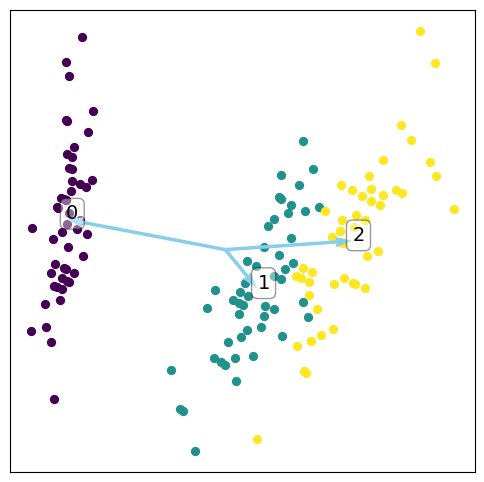

In [9]:
plotPCA(data_iris,target_iris,centroids=centers_iris_labels, d=2)

Como mencionamos el proceso de clustering es una tarea de exploración de datos, lo cual implica que normalmente no se cuenta con información relativa a los resultados esperados del análisis. Algunos de los resultados esperados podrían ser:

- El número de grupos $K$
- El tamaño de los grupos (número de elementos en cada cluster)
- La densidad de los grupos
- La posición de los clusters

Existen muchas tareas donde se aplica el proceso de clustering, las cuales van desde  aplicaciones de recuperación de información, biología, medicina, negocios, entre otros.

Podemos sumarizar el proceso de clustering como sigue:

1. Definición del dominio, lo cual implica:
    - identificar los objetos a analizar
    - determinar el propósito de generar grupos
    - el conjuto de características que describen los objetos
2. Definir una función de comparación, es decir como se determina que tan parecidos son los objetos
3. Definir como medir la calidad de los gurpos encontrados.
4. Determinar el algoritmo de clustering a utilizar

### Medidas de distancia/similitud

Una ves definido el dominio del problema es necesario contar un mecanismo para comparar los objetos en la colección. Lo anterior con la finalidad de decir que tan similares o distante es un objeto $x_i$ con respecto de otro $x_j$. Como ya hemos visto en la sección anterior, para comparar objetos definidos en un espacio vectirial, se puede utilizar una función de distancia $d$ o bien una función de similitud $\mathit{sim}$. Distancia y similitud están relacionados, desde que dos objetos que están a una distancia pequeña se puede decir que son similares.  En la siguente tabla se resumen algunas de las funciones de distancia reportadas en la literatura:

|Nombre|Función &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:--:|:--:|
|Minkowski | $$L_q(x_i,x_j)=\sqrt[q]{\sum_{k=1}^N (x_{ik}-x_{jk})^q}$$|
|**Coseno** (simulitud)   | $$\cos(x_i,x_j)=\frac{\sum_{k=1}^N x_{ik}*x_{jk}}{\sqrt{\sum_{k=1}^N x_{ik}^2} \sqrt{\sum_{k=1}^N x_{jk}^2}}$$|
**Coseno** (distancia)   | $$dcos(x_i,x_j)=1-\cos(x_i,x_j)$$|
|Divergencia de Kullback-Liebler| $$kld(x_i,x_j)=\sum_{k=1}^N x_{ik}* \log{\frac{x_{ik}}{x_{jk}}}$$|

## Medidas de calidad

Evaluar si un agrupamiento $G$ es **"bueno"** o no, no es una tarea simple, desde que no existe un criterio definitivo para determinarlo. Sin embargo se han propuesto muchos criterios de evaluación, los cuales podemos dividir en externos e internos.

### Medidas internas

Este tipo de medidas evalúan que tan compactos son los clusters mediante el uso de una medida de similitud o distancia. Esta clase de métricas generalmente intentan medir la cohesión en cada cluster (intra-cluster), la separación de los diferentes clusters (inter-cluster) o bien una combinación de ambas. Algunos ejemplos son:

#### La suma de los errores al cuadrado (SSE o inercia)

SSE es la medida más simple y consiste en calcular la suma de la distancia de todos los objetos con respecto de los centroides de sus respectivos grupos. Se cálcula mediate la siguente formula:

$$\mathit{SSE} = \sum_{k=1}^{K} \sum_{\forall x_i \in G_k} (x_i-c_k)^2$$

donde $G_k$ es el $k$-ésimo cluster y $c_k$ es el centroide del grupo. SSE es una forma simple de medir que tan diferentes son los elementos en un cluster con respecto de su centro geométrico. Esta medida permite maximizar la similitud entre objetos en el mismo grupo mediante la minimización del SSE.


#### Coeficiente de Silueta

El coeficiente de silueta trata de minimizar la distancia intracluster mientras maximiza la distancia inter-cluster. El coeficiente $\mathit{sil}(G)$  para un conjunto de clusters $G$ se determina como sigue:

1. Para un  elemento  $x_i \in G_A$ su distacia promedio $a_i$ con respecto de todo los elementos en su mismo cluster se cálcula como sigue:

$$a_i=\frac{1}{m_A-1}\sum_{\forall_{x_j} \in G_A} d(x_i,x_j)$$

2. Se cálcula su distancia promedio con mínima $b_i$ con respecto a los elemento que no están en el mismo cluster al que pertenece $x_i$

$$b_i=\min_{G_B \neq G_A}\frac{1}{m_B}\sum_{\forall_{x_j} \in G_B} d(x_i,x_j)$$

3. Con el fin de tratar de maximizar la separación entre $x_i$ y los elementos que no están en su mismo grupo, mientras se minimiza la distancia promedio con los que se encuentran en su mismo grupo; se realiza el siguiente cociente:

$$\mathit{sil}(x_i)=\frac{b_i-a_i}{\max(a_i,b_i)}$$

4. Se suma el coeficiente para todos los elementos en un mismo clusters

$$\mathit{sil}(G_k)= \frac{1}{m_k} \sum_{x_i} \mathit{sil}(x_i)$$

5. Finalmente se suman los coeficientes de cada grupo para obtener el coeficiente global

$$\mathit{sil}(G)= \frac{1}{K} \sum_{k=1}^K \mathit{sil}({G_k})$$

Está métrica tiene un costo mucho mayor que el SSE ya que en el peor caso se requiere conocer la distancia entre todos los elementos de la colección lo cual no es factible para coleccion muy grandes.



### Medidas externas

Las medidas externas requeiren que se conozcan a priori el número de grupos, así como la pertenencia de los elemetos a cada uno de ellos. Algunas de la medidas que pueden utilizarse son $\mathit{precision}$, $\mathit{recall}$ y $F_1$. Si recodamos:

$$\mathit{recall}=\frac{tp}{tp+fn}$$

$$\mathit{precision}=\frac{tp}{tp+fp}$$

$$F_1=2 \frac{precision \cdot recall}{precision + recall}$$


donde $tp$ son los verdaderos positivos y $fn$ los falsos negativos, en el contexto de clustering dado un grupo $G_k$ los $tp$ serían los elementos que fueron asignados a $G_k$ y sí pertenecen a $G_k$. Por otro lado los $fn$ serían los elementos que fueron asignados $G_k$ sin pertenecer a él. Los falsos positivo $fp$ son los elementos que fueron asignados a un cluster diferente a $G_k$.

### Índice Rand Ajusntado (ARI)

De forma breve, ARI mide las similitudes de las particiones de dos asignaciones diferentes, ignorando las posibles permutaciones y ajustando la puntuación cerca de los valores 0 cuando las particiones se generan al azar. La versión no ajustada del índice Rand (RI) se describe mediante la siguiente fórmula:

$$\mathit {RI} = \frac{a + b}{C_2 ^ {n}},$$

donde $C_2 ^{n}$ es el número total de pares que se pueden formar a partir de una base de datos de tamaño $n$, es decir, ${n} \choose{2}$. Sea $T$ el conjunto de particiones "reales" (ground truth) y  $P$ el conjunto de particiones creado por el algoritmo de clustering, $a$ el número de pares que perteneces al mismo grupo en $T$ y $P$ y $b$ el número de pares que están en diferentes particiones tanto $P$ como en $T$. La versión ajustada (ARI) se define mediante la siguiente  ecuación:

$$\mathit{ARI} = \frac{\mathit{RI}-E[\mathit{RI}]}{\max ({\mathit{RI}})-E[\mathit{RI}]},$$

donde $E$ es el valor esperado.

Estas y otras métricas de calidad de clustering ya están implementadas en `sklearn.metrics` https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

## Algoritmos de Clustering
Los diferentes algoritmos de clustrering pueden ser divididos con respecto a como crean los grupos, esto es en si lo hacen de forma jerárquica o particional. Un algoritmo particional crea el conjunto de clusters dividiendo los objetos en grupos disjuntos, lo cual se puede realizar hasta obtener grupos con un único elmento. Mientras que los métodos jerárquicos permiten la existencia de sub-grupos, es decir grupos anidados.

### Algoritmos jerarquícos

El proceso  jerarquíco puede verse como un árbol binario (dendrograma) en el que las hojas son los clusters que contienen un solo elemento, los nodos internos representan la unión de sus dos hijo y la raíz sería un único cluster que contiene todos los objetos en la colección.

| |
|:--:|
| 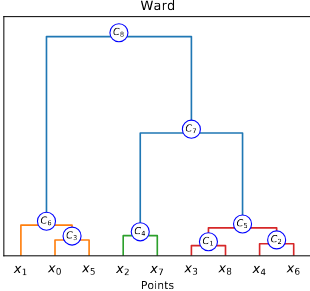 |
|**Dendrograma (Clustering Jerárquico)**|

Los métodos  jerárquicos puede construirse de forma aglomerativa o divisiva. En ambos casos, el proceso de agrupamiento puede describirse mediante el árbol dendorgrama, donde las hojas son los grupos que contienen un solo elemento. Los nodos internos representan la unión de sus dos hijos (aglomeración) o la división de un nodo padre (división). La raíz es un clúster único que contiene todos los objetos de la colección. El dendrograma representa una estructura jerárquica para los datos. Este es más informativo que el agrupamiento por algoritmos particionales. La agrupación jerárquica tiene la ventaja de que no necesariamente se requiere el número de grupos $K$ como parámetro de entrada. Además, los algoritmos jerárquicos suelen ser deterministas (es decir, se logra la misma jerarquía para el mismo conjunto de entradas-salidas). Sin embargo, son más costosos que los algoritmos particionales

En la siguiente sección describiremos brevemente en que consites una estrategía aglomerativa

### Criterios de unión (linkage)
El criterio de unión de clusters define que medida se utiliza para unir los grupos en cada nivel de dendograma. Suponga que dos elementos $x_i$ y $x_j$ tal que  $x_i \in G_p$, $x_j \in G_q$ y  $c_p$, $c_q$ son la media geométrica(centroide) de los grupos $G_p$ y  $G_q$ respectivamente.  Se puede elegir que clusters mezclar mediante alguno de los siguientes criterios:

- **Single**: Une los dos clusters $G_p$ y $G_q$ que contienen el el par ($x_i$, $x_j$) tal que su distancia es mínima.   
- **Complete**: Se eligen $G_p$ y $G_q$ contienen el par de elementos $(x_i,x_j)$ tal que su distancia máxima es la menor.
- **Centroid**: Se unen $G_p$ y $G_q$ tal que la distancia de sus centroides es mínima.
- **Ward**: Se unen los dos clusters que minimizan en incremento de la varianza de clustering.  

### Librerías de clustering jerárquico

#### scipy
La biblioteca scipy proporciona una implementación eficiente de clustering jerárquico que permite utilizar diferentes criterios de `linkage` y generar un dendograma de los datos. El modulo se encuentra en `scipy.cluster.hierarchy`. A continuación presentamos un ejemplo del como utiliza la librería.  

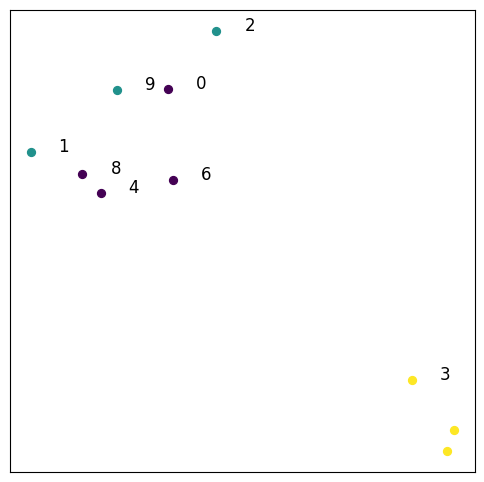

In [10]:
# Importamos la bibliotea de clustering jerarquíco
from scipy.cluster.hierarchy import dendrogram, linkage
# Generamos un ejemplo datos con tres clusters
X,y=make_blobs(n_samples=10, random_state=5)
plotClusters(X, y)
for i,z in enumerate(X):
    x,y=z
    plt.annotate(f"${i}$",(x+0.5,y),ha='center', size=12)
# graficamos los clusters


In [11]:
def anota_dendograma(D, ax):
      bbox_props = dict(fc="white", ec="b",boxstyle='circle')
      ll=list(set(np.array(D['dcoord']).flatten()))
      ll.sort()
      for j, d in zip(D['icoord'], D['dcoord']):
        x = 0.5 * sum(j[1:3])
        y = d[1]
        #plt.plot(x, y, 'sr', markersize=10)
        ax.annotate("$C_{%d}$" %(ll.index(y)+len(X)-1) , (x, y), xytext=(0, 8),textcoords='offset points',va='top',size=9
                     ,ha='center', bbox=bbox_props)


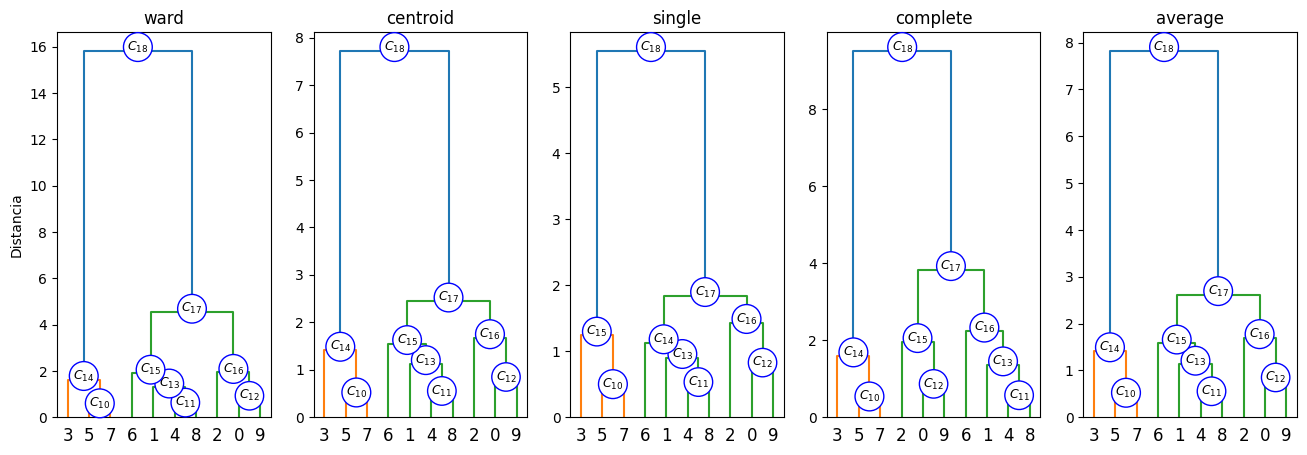

In [12]:
# Obtenemos distintons clustering e gráficamos el dendrogram
fig,axes=plt.subplots(1,5, figsize=(16,5))
axes[0].set_ylabel('Distancia')
for i,lk in enumerate(('ward','centroid','single','complete','average')):
      Z=linkage(X,lk)
      Dz=dendrogram(Z,ax=axes[i])
      axes[i].set_title(lk)
      anota_dendograma(Dz,axes[i])


En el dendrogrma la altura de cada nodo representa el costo (distancia) de unir los clusters, correspondientes. Para el ejemplo, en el caso de complete unir 4 y 8 tiene un coste similar a unir 5 y 7, pero unir $C_{16}$  y $C_{13}$ es más costoso.

La matriz $Z$ devuelta por linkage de dimensión $n-1 \times 4$. En la $i$-ésima iteración, los grupos con índices $Z_{i,0}$ y $Z_{i, 1}$ son conbinaddo para formar un nuevo grupo. $Z_{i, 2}$ es la distancia entre los grupos $Z_{i,0}$ y $Z_{i, 1}$. El cuarto valor $Z_{i, 3}$ representa el número de observaciones originales en el grupo recién formado.

In [13]:
print("El la ultima iteración se unen los clusters:", (Z[8,0], Z[8,1]))
print("El costo es de:", Z[8,2])
print("El número de elementos en C18 es:", Z[8,3])

El la ultima iteración se unen los clusters: (np.float64(14.0), np.float64(17.0))
El costo es de: 7.829655096475191
El número de elementos en C18 es: 10.0


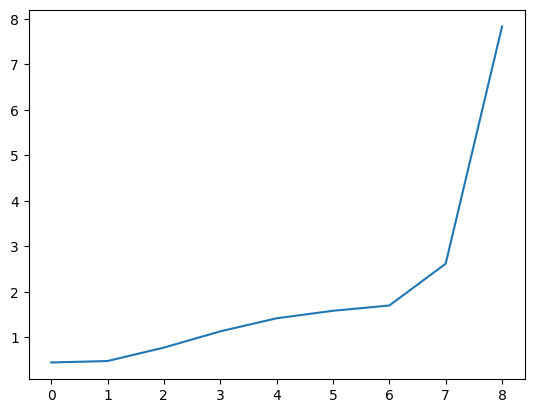

In [14]:
plt.plot(Z[:,2])

### Cortar el dendograma
El dendrograma muestra la similitud entre la jerarquía de clusters, pero también puede utilizarse para determinar el número de clusters, así como los elementos en cada uno. Esto de puede conseguir mediante un "corte" horizontal a una determinada altura del dendrograma, el número de ramas que sobrepasan por encima del será el número de clusters.


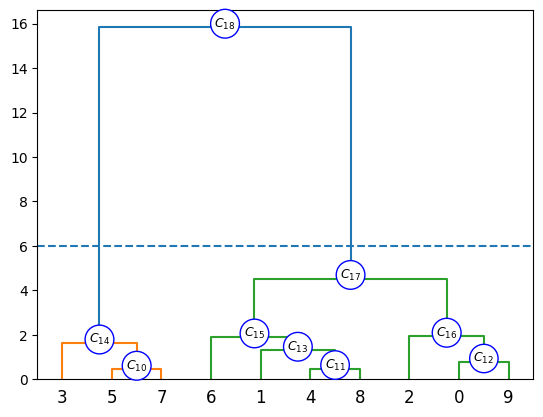

In [15]:
# cortando a una altura de 6 tendráimo dos clusters
Z=linkage(X,'ward')
Dz=dendrogram(Z)
plt.axhline(6,0,10,linestyle='dashed')
anota_dendograma(Dz,plt)

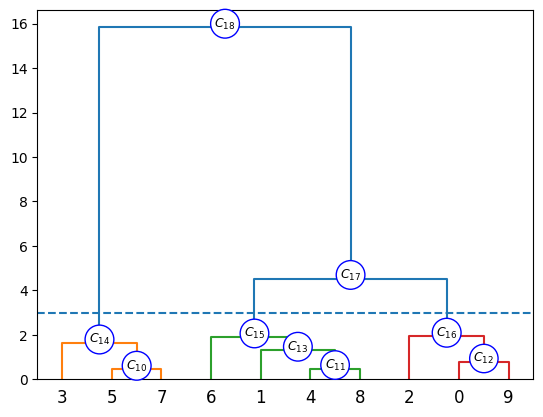

In [16]:
# cortando a una altura de 3 tendríamos dos clusters
Z=linkage(X,'ward')
Dz=dendrogram(Z,color_threshold=3) # con la variable color_threshold especificamos la altura de corte (3 clusters, 3 colores)
plt.axhline(3,0,10,linestyle='dashed')
anota_dendograma(Dz,plt)

[3 2 3 1 2 1 2 1 2 3]


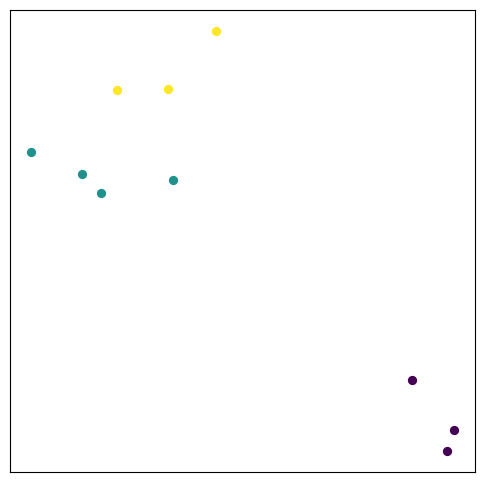

In [17]:
# Podemos obtener las etiquetas de los grupos mediante la funcion fcluster
K=3 # este sería el número de clusters
yp=fcluster(Z, K, criterion='maxclust') # semejante a predict
print(yp)
plotClusters(X,yp)

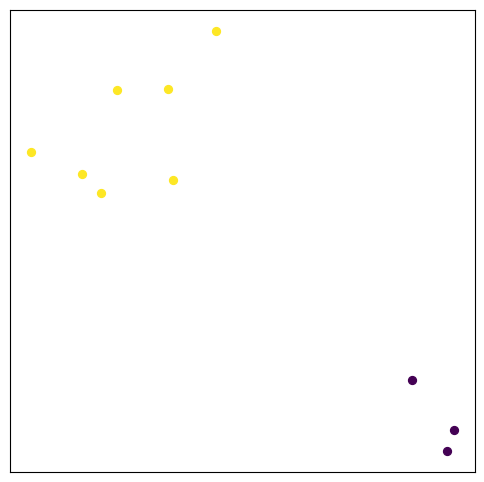

In [18]:
# Para dos clusters
yp=fcluster(Z, 2, criterion='maxclust') # semejante a predict
plotClusters(X,yp)

### Algoritmos particionales

En este tipo de algoritmos sin duda el más conicido es $K$-Means

#### $K$-Means

Es un algoritmo basado en particionado. El algoritmo requiere como entrada la colección $X$ y el número de clusters $K$. El proceso comienza seleccionando $K$ elementos de $X$, los cuales son utilizados como los centroides iniciales. Posteriormente cada punto es asignado a su centroide más cercano, todos los elementos asignados a un mismo centroide forman un cluster. Una vez asignados todos lo elementos se cálcula el centroide $c_k$ para cada uno de los grupos. Se repiten el proceso de asignación y actualización de los centroides hasta que no hay cambios en los centroides. Podemos resumir el algoritmo en el siguiente listado:

------
**Algoritmo básico para K-Means**


------
1. Seleccionar $K$ objetos de $X$ como centroides iniciales
2. **repetir**
3. &nbsp;&nbsp;&nbsp;&nbsp;Para cada $x_i \in X$ asignar $x_i$ al grupo representado por su centroide más cercano
4. &nbsp;&nbsp;&nbsp;&nbsp;Recálcular los centroides en base a los grupos obtenidos
5. **hasta** que los centroides no cambien
------
------


Para el paso 3 se utiliza alguna función comparación, ya sea de distancia o similitud. En esta punto algunas de las consideraciones que hay que tomar para asegurar convergencia del método $K$-Means se resumen en la siguiente tabla:

   
|Función de comparación| valor para el centroide | Función objetivo &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:---:|:---:|:---:|
|Distancia Euclidiana| media|  $$\min \sum_{k=1}^{K}  \sum_{\forall x_i \in G_k} (x_i-c_k)^2$$|
|Distancia Manhattan | mediana|  $$\min \sum_{k=1}^{K} \sum_{\forall x_i \in G_k} |x_i-c_k|$$|
|Similitud Coseno    | media|  $$\max \sum_{k=1}^{K} \sum_{\forall x_i \in G_k} \cos(x_i-c_k)$$|

La siguiente figura muestra el proceso de convergencia del $K$-Means para un conjunto de 90 elementos y $K=3$ clusters:

|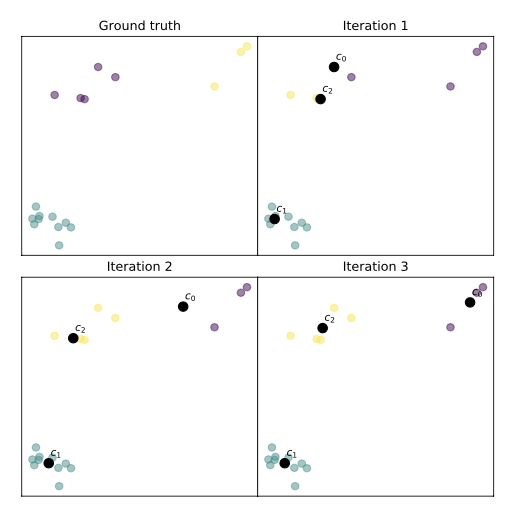|
|:--:|
|**Iteraciones $K$-Means**|

#### $K$-Centros y Farthest First Traversal

El problema de los $K$-Centros consiste en dado un número limitado de facilidades ($K$) encontrar la forma de ubicarlas de tal forma los usuarios más alejados tengan un coste mínimo para acceder a dichas facilidades. Como ejemplo suponga que hay $n$ personas en edad escolar, de las cuales conoce la ubicación de su vivienda. Se pretende construir $K$ escuelas, pero eligiendo las posiciones de tal forma  que la distancia $r$ que los niños más alejados tengan que recorrer para acudir a clase sea mínima. En este las distintas ubicaciones pueden verse como un conjuto de puntos en un espacio bidimensional. Para solucionar el problema deben elegirse las posiciones en las que debe construirse cada escuela minimizando la distancia máxima $r$.  

Si consideramos que los puntos que generamos previamente en los blobs corresponden a las posiciones de los habitantes y se quieren construir 3 escuelas; entonces una solución simple es ubicarlas en la posición correspondiente al centroide de cada nube de puntos:

|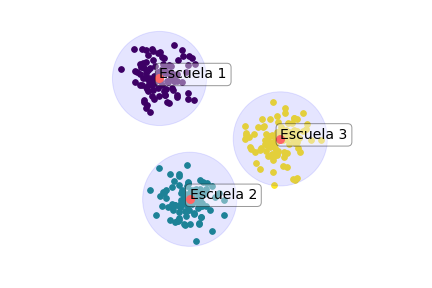|
|:---:|
|**Solución ideal para los $K$-centros cuando los datos siguen una distribución gaussiana**|

desafortunadamente no todos los datos provienen de distribuciones normales con varianza unitaria. Por ejemplo no es tan obvio utilizar la misma idea para los siguientes datos:


|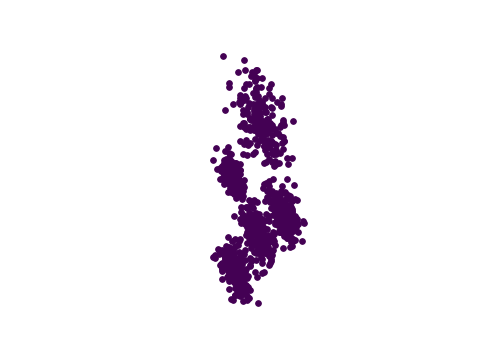|
|:----:|



Aún así podríamos utilizar $K$-means para encontrar tres clusters y construir la esculeas en los centroides.

|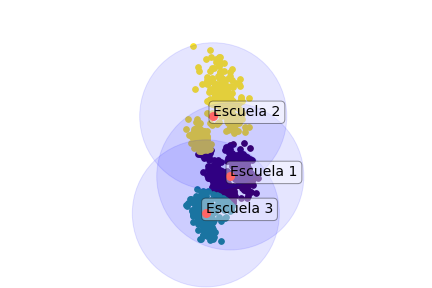|
|:----:|
|**Utilizando $K$Means para 100 ejecuciones se obtiene en promedio una distancia máxima de $r=37$ y un $SSE=128141.13$**|

Como puede observar en la figura $𝐾$-Means tiende a favorecer la zona más densa (ahí quedaron 2 escuelas). Lo cual podría ser bueno, ya quiere decir que la mayoría de los estudiantes tienen que desplazarse poco, pero es muy probable que para este caso la distancia máxima no sea mínima.

Para el caso en que se desea minimizar la distancia máxima resulta más convemiente resolver el problema mediante  el uso de Farthest First Traversal FFT.

|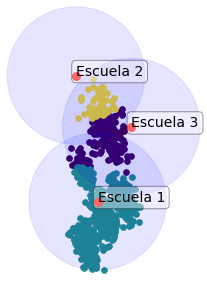|
|:----:|
|**Utilizando FFT para 100 ejecuciones se obtiene en promedio una distancia máxima de $r=33.38$ y un $SSE=24198.58$**|

**Farthest First Traversal (FFT)**

FFT es un algoritmo que permite seleccionar $K$ centros de una colección de objetos. Un centro a diferencia de un centroide es un elemento que forma parte de la colección de datos. En FFT cada centro es seleccionado de tal forma que cualquier objeto $x_i \in X$ está a lo más  una distancia $r$ de uno de los centros. Al igual que $K$Means, FFT es un algoritmo de pariticionado, solo que en este caso cada $G_k \in G$ será defino en base a  la partición generada por los centros, utilizaremos $R_C$ para referiremos al conjunto de centros generados por el algoritmo.

Este algoritmo fue inicialmente propueste por Teofilo Gónzalez como un aproximación a la solución del problema de $K$-Centros, la cual es a lo más dos veces la solución óptima. Utilizando FFT podemos calcular un conjunto $R_C$, conde cada $c_j \in R_C$ son lejanos entre si. Esto se consigue simulando un recorrido, donde en cada iteración $k$, $c_k$ es seleccionado como el elemento más alejado de los elementos ya seleccionados. Sea  $r_k$ la distancia utilizada para seleccionar el centro $c_k$, entonces en la iteración $k$ se cumple que:

- Cualquier par de objetos $x_i,x_j \in X$ se encuentran al menos a distancia $r_k$ el uno del otro.
- Cualquier elemento $x_i \in X$ se ecuentra a lo más a distancia $r_k$ de uno de los centros $c_j \in R_C$ (cada elemento se asigna a la partición de su centro más cercano)

Para facilitar la definición del algoritmo definimos $d_{\min}(x)$ como la distacia entre un elemento $x$ y su centro más cercano en $R_C$, entonces:
$$d_{\min}(x)=\min\{d(x,c) \mid c \in R_C\}$$

------
**Algoritmo Farthest First Traversal**


------
1. $c_1 \gets x_i$, donde $x_i$ es seleccionado aleatoriamente de $X$
2. $R_C \gets \{c_1\}$
3. **Mientras** $|R_C|<K$
4. &nbsp;&nbsp;&nbsp;&nbsp; $c_n \gets \arg\max\{d_{\min}(x) \mid x \in X \setminus R_C\}$
5. &nbsp;&nbsp;&nbsp;&nbsp; $r \gets \max\{d_{\min}(x) \mid x \in X \setminus R_C\}$
6. &nbsp;&nbsp;&nbsp;&nbsp; $R_C \gets R_C \cup \{w\}$
7. $G \gets \{G_1,G_2,...G_k\}$
------
------

donde cada $G_k$ es el conjuto de los elemento $x_i$ que tiene como su centro más cercano al centro $c_k$.

La siguiente figura muestra la evolución de algoritmo FFT, puede observarse que la distancia máxima disminuye a cada iteración; asi como el orden en que se eligen los puntos.

|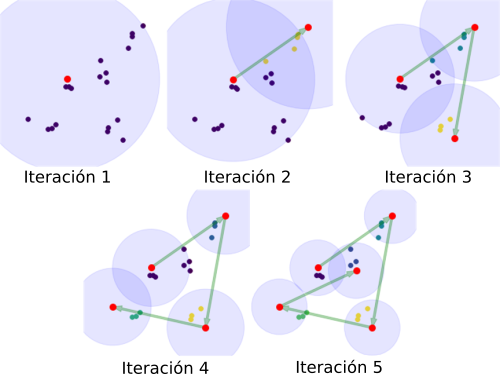|
|:----:|
|**FFT para $K=5$ sobre 5 nubes de puntos generadas asumiendo una distribución normal**|

FFT tiene la ventaja adicional que su complejidad está acotada por $O(D K n)$ donde $D$ es la dimensión de los datos, $n$ el número de elementos en la base de datos y $K$ el número de centros. La solución mencionada es la mejor solución conocida para el problema. Por otro lado la solución obtenida es a lo más 2 veces la solución ópitma. Si utilizamos $K$Means la solución es $O(K D n I)$ donde I es el número de iteraciones.  Finalmente hay que notar que los dos algoritmos optimizan variables difierentes, mientras que $FFT$ minimiza la distancia máxima de los datos a uno de los centros; $K$ means optimiza el error cuadrático $SSE$.  

## Determinando el número de clusters

Este problema ha sido objeto de muchos estudios, pero solo mencionaremos brevemente dos métodos de los muchos que existen en la literatura.

**Método de Elbow**: Consiste en calcular el valor del  𝑆𝑆𝐸  para valores continuos de  𝐾  y elegir el valor en que se da el cambio máximo en el valor de  𝑆𝑆𝐸 .

**Método de la silueta**: En este caso de cálcula el valor del coeficiente de silueta y se elige el valor de  𝐾  que presente el valor máximo del score.

En la siguente gráfica se muestra el valor de ambos criterios para el data set de iris utilizando. Como puede verse para este caso utilizando el criterio de Elbow el valor óptimo sería  $K=3$ ; mientras que si utilizamos Silueta esto sería  $K=2$.

|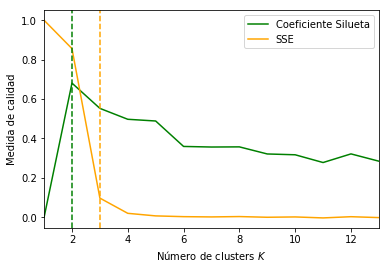|
|:----:|
|**Ejemplos de criterios de selección del valor de K para la DB Iris**|

## Tarea

### Evaluación de algoritmos de clustering
<div class="alert alert-success">
Para la actividad correspondiente a clustering deberá proporcionar implementaciones propias de los algoritmos de clustering FF-Traversal y $K$-Means. Utilizar la plantilla  `SimpleClustering.py`.

Una vez que cuente con sus implementaciones realizar las siguientes actividades:

1. Identificar un conjunto de datos 
2. Con los métodos implementados y al menos una estrategía jerárquica para agrupar los datos del problema elegido, utilizando dos funciones de distancia diferentes.
3. Mediante el uso de los métodos de Elbow y Silueta, determine el número "óptimo" de clusters para el problema, utilizando los 3 algoritmos de clustering.
4. Realice una comparativa de la calidad de los clusters obtenidos por cada una de las estrategías. Utilice medidas internas, y también externas cuando se cuente con los datos ya etiquetados.
5. Con base en los puntos 2, 3 y 4 Determine cual sería la mejor combinación de algoritmo, métrica y número óptimo de clusters para su problema.
6. Realice un reporte de las estrategias que haya aplicado. El documento deberá incluir las siguientes secciones:
  - Introducción
  - Sección que describa el análisis realizados y los resultados obtenidos para cada dataset.
  - Conclusiones
  - Referencias

  **Nota**: Subir un documento en formato pdf. Si utiliza estrategias adicionales por favor incluir las referencias. Si tienes alguna pregunta respecto al material o la actividad puedes ingresar al foro de dudas.

## Ejemplo de randomClustering

In [31]:
data,target=make_blobs(n_samples=50, centers=4)
cl=Clustering()
cl.fit(data)

In [32]:
yp=cl.predict(data)
set(yp)

{np.int64(1), np.int64(40), np.int64(44)}

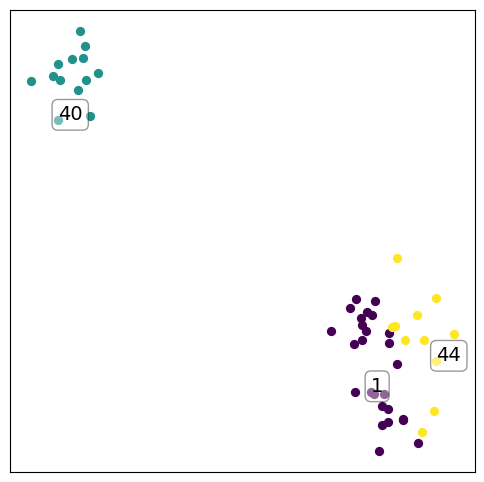

In [33]:
plotClusters(data,yp,centroids=cl.centroids_)# graficar los clusters con los centroides elegidos

In [22]:
cl.fit(data)

In [23]:
yp=cl.predict(data)
yp

array([ 7,  1, 12, 12, 12, 12,  1,  7,  1, 12,  7,  1, 12, 12,  7,  7,  7,
       12,  7, 12, 12, 12,  7,  7,  1, 12,  1,  1,  7, 12, 12,  7,  7,  7,
       12, 12,  7,  7,  7,  7, 12, 12, 12, 12, 12, 12,  1, 12, 12, 12])

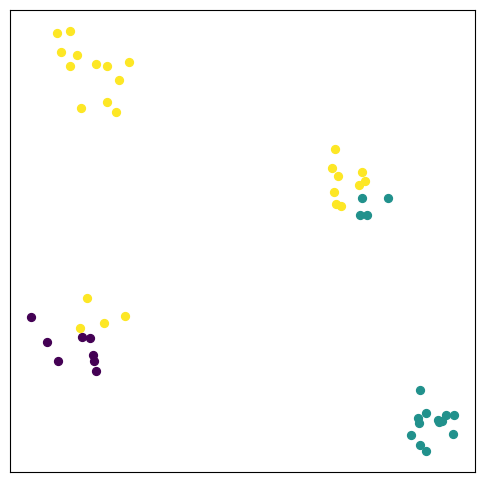

In [24]:
plotClusters(data,yp)# graficar los clusters con los centroides elegidos

In [25]:
from sklearn.cluster import KMeans

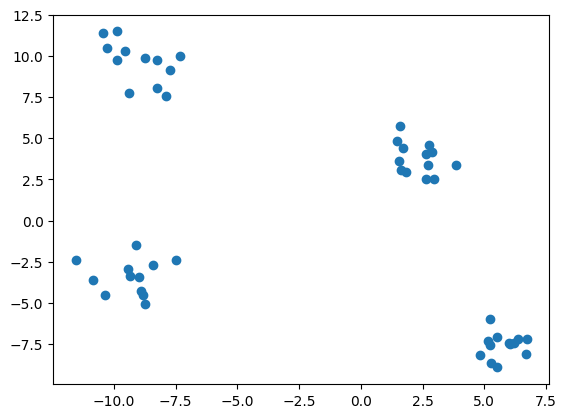

In [26]:
plt.scatter(data[:,0], data[:,1])

In [27]:
clt=KMeans(n_clusters=3,)

In [28]:
clt.fit(data)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [29]:
yp=clt.predict(data)

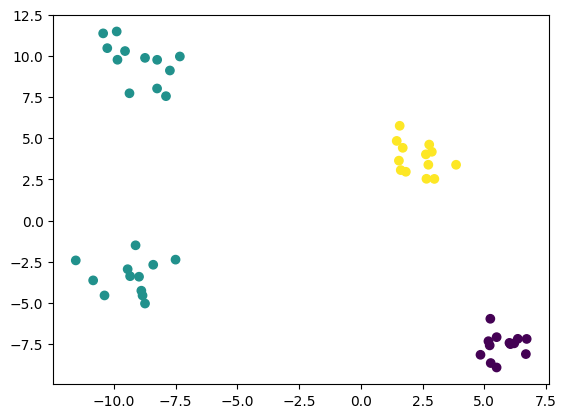

In [30]:
plt.scatter(data[:,0], data[:,1], c=yp)